In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

class ADMM_NN:
    """ Class for ADMM Neural Network. """

    def __init__(self, n_inputs, n_hiddens, n_outputs, n_batches):
        """
        Initialize variables for NN.
        Raises:
            ValueError: Column input samples, for example, the input size of MNIST data should be (28x28, *) instead of (*, 28x28).
        :param n_inputs: Number of inputs.
        :param n_hiddens: Number of hidden units.
        :param n_outputs: Number of outputs
        :param n_batches: Number of data sample that you want to train
        :param return:
        """
        self.a0 = torch.zeros((n_inputs, n_batches))

        self.w1 = torch.zeros((n_hiddens, n_inputs))
        self.w2 = torch.zeros((n_hiddens, n_hiddens))
        self.w3 = torch.zeros((n_outputs, n_hiddens))

        self.z1 = torch.rand((n_hiddens, n_batches))
        self.a1 = torch.rand((n_hiddens, n_batches))

        self.z2 = torch.rand((n_hiddens, n_batches))
        self.a2 = torch.rand((n_hiddens, n_batches))

        self.z3 = torch.rand((n_outputs, n_batches))

        self.lambda_larange = torch.ones((n_outputs, n_batches))

    def _relu(self, x):
        """
        Relu activation function
        :param x: input x
        :return: max 0 and x
        """
        return F.relu(x)

    def _weight_update(self, layer_output, activation_input):
        """
        Consider it now the minimization of the problem with respect to W_l.
        For each layer l, the optimal solution minimizes ||z_l - W_l a_l-1||^2. This is simply
        a least square problem, and the solution is given by W_l = z_l p_l-1, where p_l-1
        represents the pseudo-inverse of the rectangular activation matrix a_l-1.
        :param layer_output: output matrix (z_l)
        :param activation_input: activation matrix l-1  (a_l-1)
        :return: weight matrix
        """
        pinv = torch.pinverse(activation_input)
        weight_matrix = torch.mm(layer_output.float(), pinv.float())
        return weight_matrix

    def _activation_update(self, next_weight, next_layer_output, layer_nl_output, beta, gamma):
        """
        Minimization for a_l is a simple least squares problem similar to the weight update.
        However, in this case the matrix appears in two penalty terms in the problem, and so
        we must minimize:
            beta ||z_l+1 - W_l+1 a_l||^2 + gamma ||a_l - h(z_l)||^2
        :param next_weight:  weight matrix l+1 (w_l+1)
        :param next_layer_output: output matrix l+1 (z_l+1)
        :param layer_nl_output: activate output matrix h(z) (h(z_l))
        :param beta: value of beta
        :param gamma: value of gamma
        :return: activation matrix
        """
        # Calculate ReLU
        layer_nl_output = self._relu(layer_nl_output)

        # Activation inverse
        m1 = beta * torch.mm(next_weight.t(), next_weight)
        m2 = gamma * torch.eye(m1.shape[0], device=m1.device)
        av = torch.inverse(m1.float() + m2.float())

        # Activation formula
        m3 = beta * torch.mm(next_weight.t(), next_layer_output)
        m4 = gamma * layer_nl_output
        af = m3.float() + m4.float()

        # Output
        return torch.mm(av, af)

    def _argminz(self, a, w, a_in, beta, gamma):
        """
        This problem is non-convex and non-quadratic (because of the non-linear term h).
        Fortunately, because the non-linearity h works entry-wise on its argument, the entries
        in z_l are decoupled. This is particularly easy when h is piecewise linear, as it can
        be solved in closed form; common piecewise linear choices for h include rectified
        linear units (ReLUs), that its used here, and non-differentiable sigmoid functions.
        :param a: activation matrix (a_l)
        :param w:  weight matrix (w_l)
        :param a_in: activation matrix l-1 (a_l-1)
        :param beta: value of beta
        :param gamma: value of gamma
        :return: output matrix
        """
        m = torch.mm(w.float(), a_in.float())
        sol1 = (gamma * a + beta * m) / (gamma + beta)
        sol2 = m

        z1 = torch.zeros_like(a)
        z2 = torch.zeros_like(a)
        z = torch.zeros_like(a)

        z1[sol1 >= 0] = sol1[sol1 >= 0]
        z2[sol2 <= 0] = sol2[sol2 <= 0]

        fz_1 = gamma * (a - self._relu(z1)).pow(2) + beta * (z1 - m).pow(2)
        fz_2 = gamma * (a - self._relu(z2)).pow(2) + beta * (z2 - m).pow(2)

        index_z1 = fz_1 <= fz_2
        index_z2 = fz_2 < fz_1

        z[index_z1] = z1[index_z1]
        z[index_z2] = z2[index_z2]

        return z

    def _argminlastz(self, targets, eps, w, a_in, beta):
        """
        Minimization of the last output matrix, using the above function.
        :param targets: target matrix (equal dimensions of z) (y)
        :param eps: lagrange multiplier matrix (equal dimensions of z) (lambda)
        :param w: weight matrix (w_l)
        :param a_in: activation matrix l-1 (a_l-1)
        :param beta: value of beta
        :return: output matrix last layer
        """
        m = torch.mm(w.float(), a_in.float())
        z = (targets - eps + beta * m) / (1 + beta)
        return z

    def _lambda_update(self, zl, w, a_in, beta):
        """
        Lagrange multiplier update.
        :param zl: output matrix last layer (z_L)
        :param w: weight matrix last layer (w_L)
        :param a_in: activation matrix l-1 (a_L-1)
        :param beta: value of beta
        :return: lagrange update
        """
        mpt = torch.mm(w.float(), a_in.float())
        lambda_up = beta * (zl - mpt)
        return lambda_up

    def feed_forward(self, inputs):
        """
        Calculate feed forward pass for neural network
        :param inputs: inputs features
        :return: value of prediction
        """
        outputs = self._relu(torch.mm(self.w1, inputs))
        outputs = self._relu(torch.mm(self.w2, outputs))
        outputs = torch.mm(self.w3, outputs)
        return outputs

    def fit(self, inputs, labels, beta, gamma):
        """
        Training ADMM Neural Network by minimizing sub-problems
        :param inputs: input of training data samples
        :param outputs: label of training data samples
        :param epochs: number of epochs
        :param beta: value of beta
        :param gamma: value of gamma
        :return: loss value
        """
        self.a0 = inputs

        # Input layer
        self.w1 = self._weight_update(self.z1, self.a0)
        self.a1 = self._activation_update(self.w2, self.z2, self.z1, beta, gamma)
        self.z1 = self._argminz(self.a1, self.w1, self.a0, beta, gamma)

        # Hidden layer
        self.w2 = self._weight_update(self.z2, self.a1)
        self.a2 = self._activation_update(self.w3, self.z3, self.z2, beta, gamma)
        self.z2 = self._argminz(self.a2, self.w2, self.a1, beta, gamma)

        # Output layer
        self.w3 = self._weight_update(self.z3, self.a2)
        self.z3 = self._argminlastz(labels, self.lambda_larange, self.w3, self.a2, beta)
        self.lambda_larange = self._lambda_update(self.z3, self.w3, self.a2, beta)

        loss, accuracy = self.evaluate(inputs, labels)
        return loss, accuracy

    def evaluate(self, inputs, labels, isCategories=True):
        """
        Calculate loss and accuracy (only classification)
        :param inputs: inputs data
        :param outputs: ground truth
        :param isCategories: classification or not
        :return: loss and accuracy (only classification)
        """
        forward = self.feed_forward(inputs)
        loss = torch.mean((forward - labels).pow(2))

        if isCategories:
            accuracy = (torch.argmax(labels, dim=0) == torch.argmax(forward, dim=0)).float().mean()
        else:
            accuracy = loss

        return loss, accuracy

    def warming(self, inputs, labels, epochs, beta, gamma):
        """
        Warming ADMM Neural Network by minimizing sub-problems without update lambda
        :param inputs: input of training data samples
        :param outputs: label of training data samples
        :param epochs: number of epochs
        :param beta: value of beta
        :param gamma: value of gamma
        :return:
        """
        self.a0 = inputs
        for i in range(epochs):
            print(f"------ Warming: {i} ------")
            # Input layer
            self.w1 = self._weight_update(self.z1, self.a0)
            self.a1 = self._activation_update(self.w2, self.z2, self.z1, beta, gamma)
            self.z1 = self._argminz(self.a1, self.w1, self.a0, beta, gamma)

            # Hidden layer
            self.w2 = self._weight_update(self.z2, self.a1)
            self.a2 = self._activation_update(self.w3, self.z3, self.z2, beta, gamma)
            self.z2 = self._argminz(self.a2, self.w2, self.a1, beta, gamma)

            # Output layer
            self.w3 = self._weight_update(self.z3, self.a2)
            self.z3 = self._argminlastz(labels, self.lambda_larange, self.w3, self.a2, beta)

    def drawcurve(self, train_, valid_, id, legend_1, legend_2):
        acc_train = np.array(train_).flatten()
        acc_test = np.array(valid_).flatten()

        plt.figure(id)
        plt.plot(acc_train)
        plt.plot(acc_test)

        plt.legend([legend_1, legend_2], loc='upper left')
        plt.draw()
        plt.pause(0.001)
        return 0


In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

# Load MNIST data
mnist = datasets.MNIST('./data', train=True, download=True, transform=transforms.ToTensor())

train_data = mnist.train_data.numpy().reshape(-1, 28*28).T.astype(np.float32)
train_labels = F.one_hot(mnist.train_labels, num_classes=10).numpy().T.astype(np.float32)

mnist_valid = datasets.MNIST('./data', train=False, transform=transforms.ToTensor())
valid_data = mnist_valid.test_data.numpy().reshape(-1, 28*28).T.astype(np.float32)
valid_labels = F.one_hot(mnist_valid.test_labels, num_classes=10).numpy().T.astype(np.float32)


/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:76: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:66: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:81: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:71: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [ ]:
# Parameters
n_inputs = 28*28  # MNIST image shape 28*28
n_outputs = 10    # MNIST classes from 0-9 digits
n_hiddens = 256   # number of neurons
n_batches = train_data.shape[1]  # 55000 number of samples for training
train_epochs = 15
warm_epochs = 10
beta = 5.0
gamma = 5.0


In [ ]:

# Initial Model
model = ADMM_NN(n_inputs, n_hiddens, n_outputs, n_batches)

# Warming Model
model.warming(torch.from_numpy(train_data), torch.from_numpy(train_labels), warm_epochs, beta, gamma)


------ Warming: 0 ------
------ Warming: 1 ------
------ Warming: 2 ------
------ Warming: 3 ------
------ Warming: 4 ------
------ Warming: 5 ------
------ Warming: 6 ------
------ Warming: 7 ------
------ Warming: 8 ------
------ Warming: 9 ------


------ Training: 0 ------
Loss train: 0.500, accuracy train: 0.803
Loss valid: 2.322, accuracy valid: 0.810


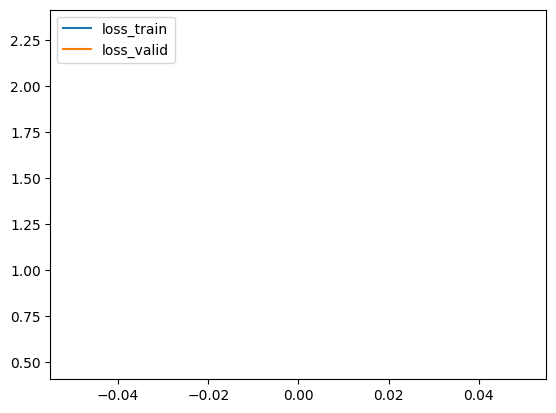

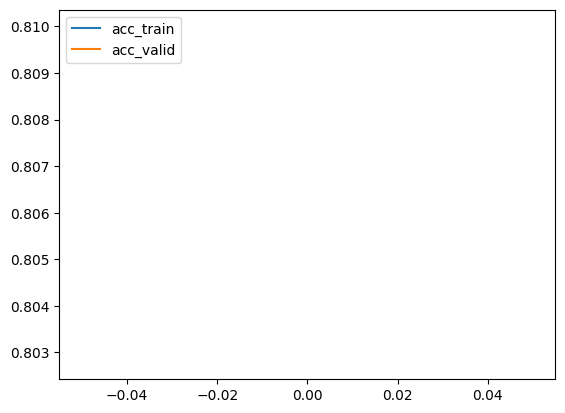

------ Training: 1 ------
Loss train: 0.562, accuracy train: 0.819
Loss valid: 2.814, accuracy valid: 0.822


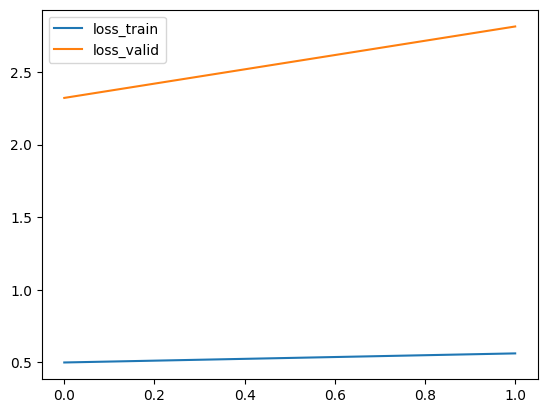

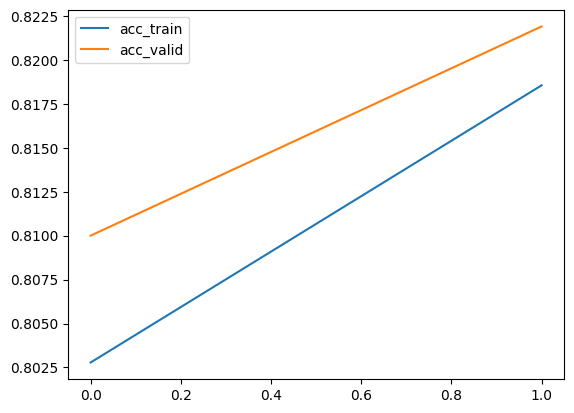

------ Training: 2 ------
Loss train: 0.602, accuracy train: 0.829
Loss valid: 3.194, accuracy valid: 0.831


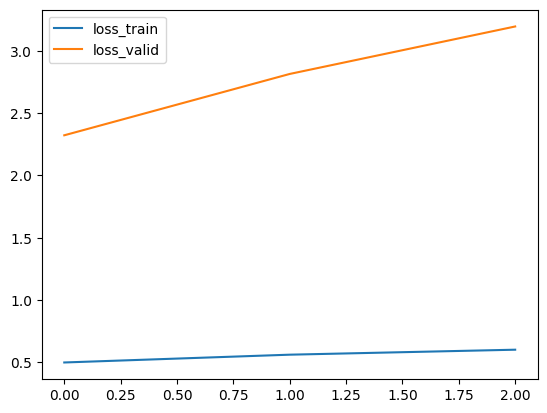

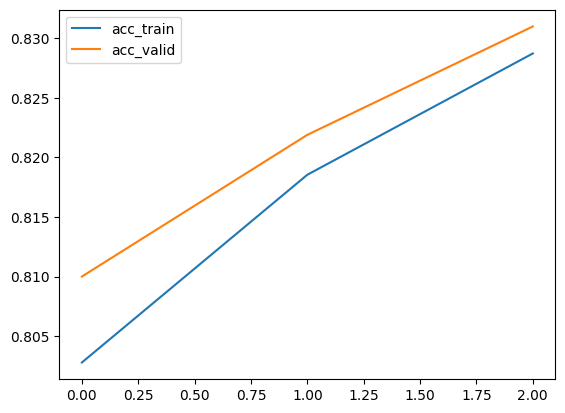

------ Training: 3 ------
Loss train: 0.519, accuracy train: 0.835
Loss valid: 3.040, accuracy valid: 0.837


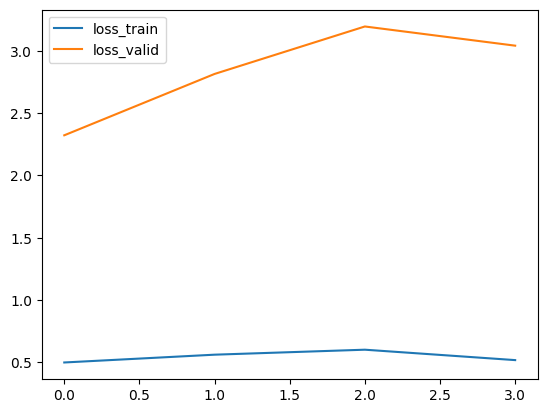

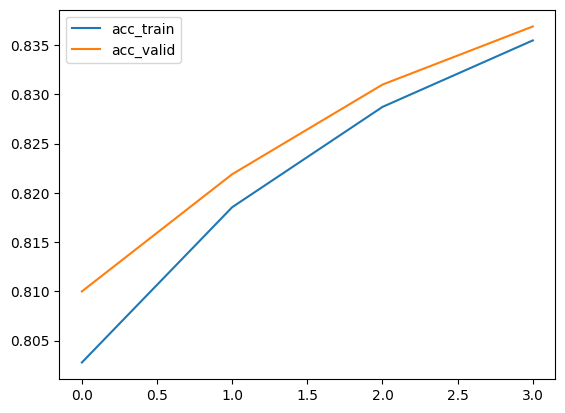

------ Training: 4 ------
Loss train: 0.487, accuracy train: 0.840
Loss valid: 3.041, accuracy valid: 0.842


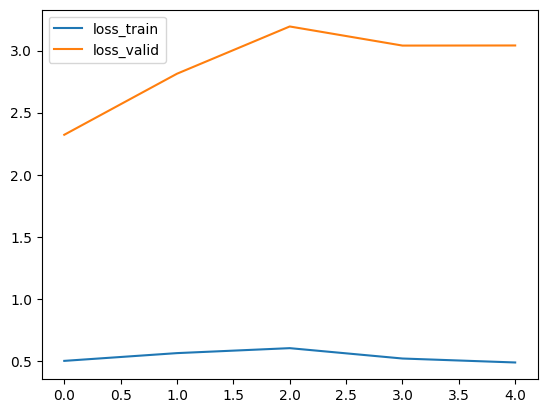

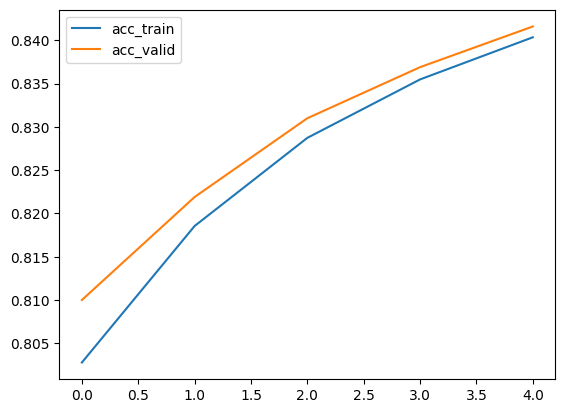

------ Training: 5 ------
Loss train: 0.396, accuracy train: 0.844
Loss valid: 2.823, accuracy valid: 0.845


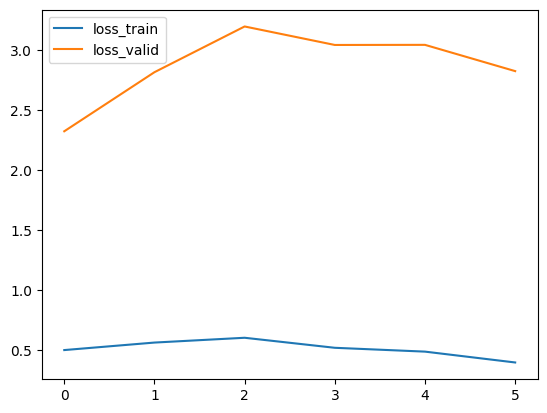

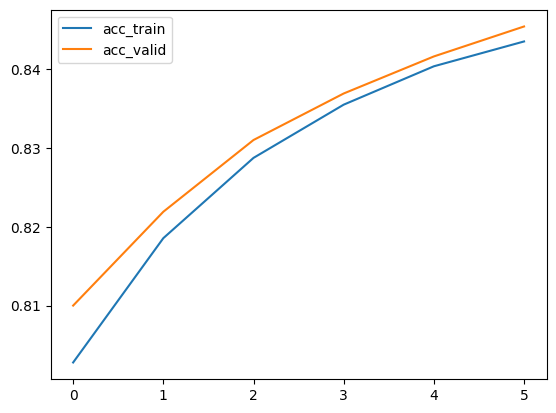

------ Training: 6 ------
Loss train: 0.361, accuracy train: 0.846
Loss valid: 2.793, accuracy valid: 0.847


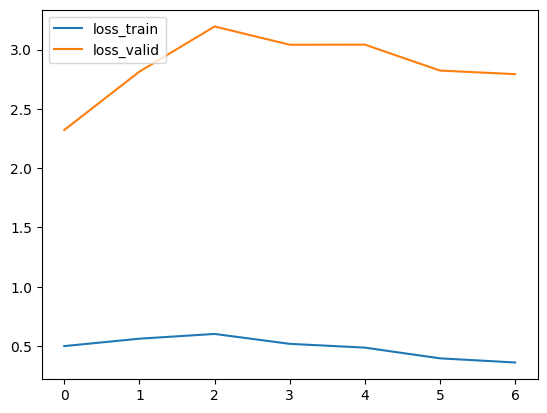

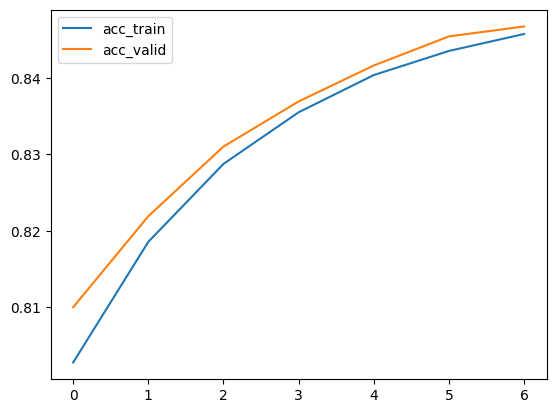

------ Training: 7 ------
Loss train: 0.292, accuracy train: 0.847
Loss valid: 2.636, accuracy valid: 0.848


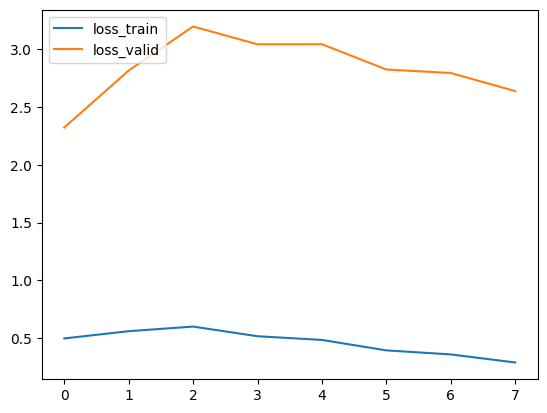

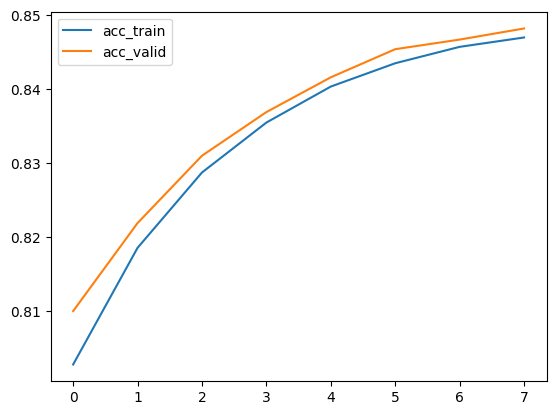

------ Training: 8 ------
Loss train: 0.265, accuracy train: 0.848
Loss valid: 2.625, accuracy valid: 0.849


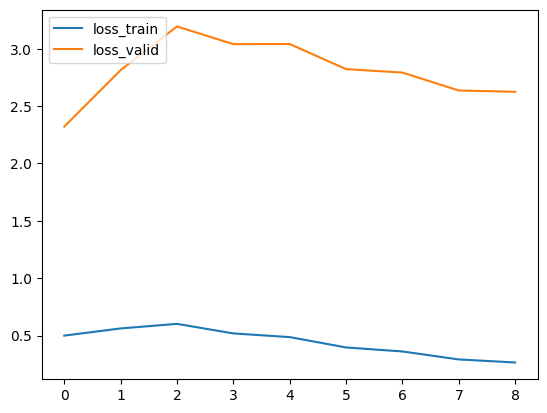

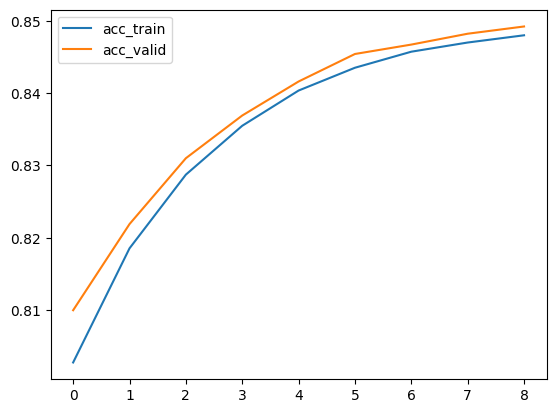

------ Training: 9 ------
Loss train: 0.216, accuracy train: 0.849
Loss valid: 2.533, accuracy valid: 0.849


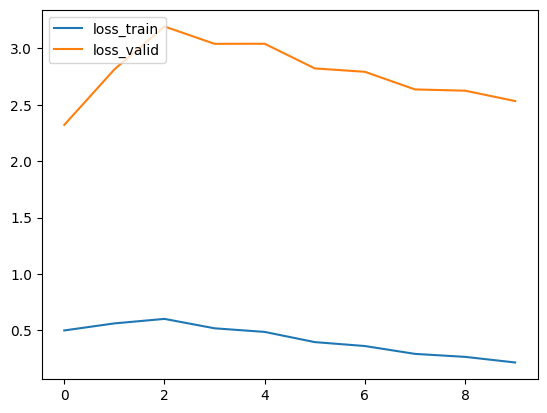

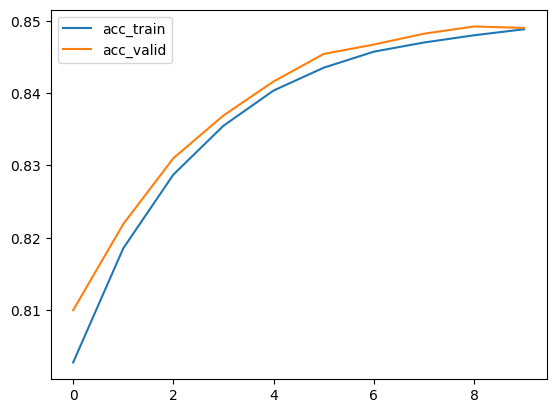

------ Training: 10 ------
Loss train: 0.197, accuracy train: 0.849
Loss valid: 2.541, accuracy valid: 0.849


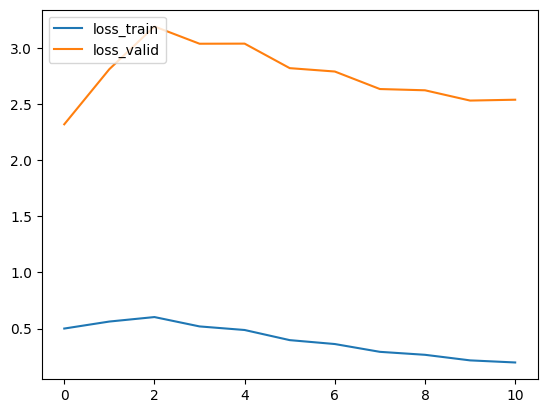

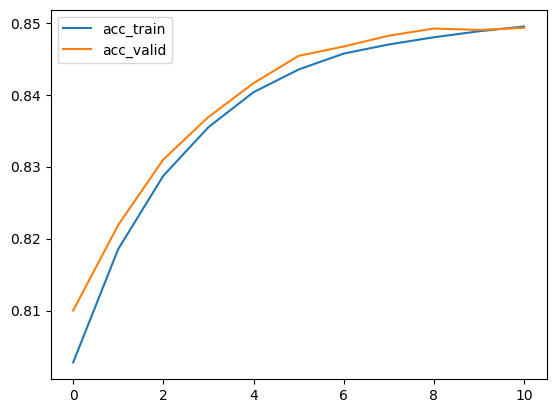

------ Training: 11 ------
Loss train: 0.162, accuracy train: 0.850
Loss valid: 2.491, accuracy valid: 0.850


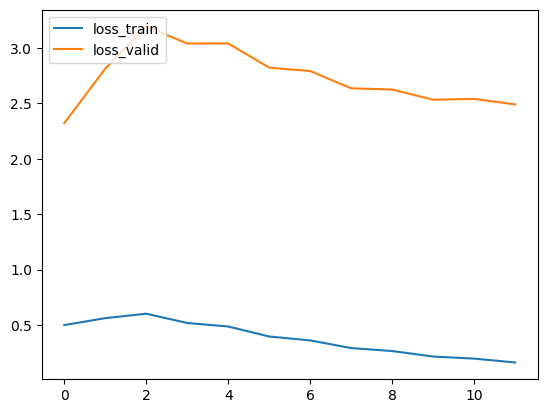

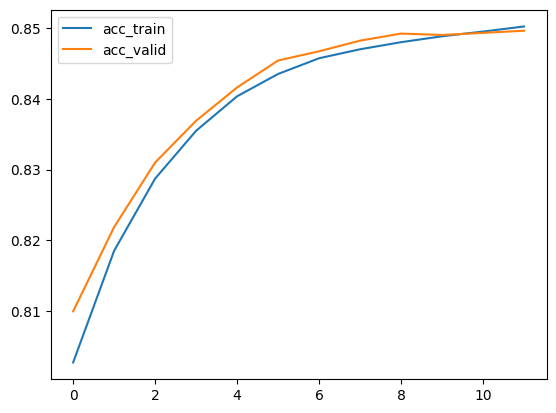

------ Training: 12 ------
Loss train: 0.149, accuracy train: 0.851
Loss valid: 2.506, accuracy valid: 0.850


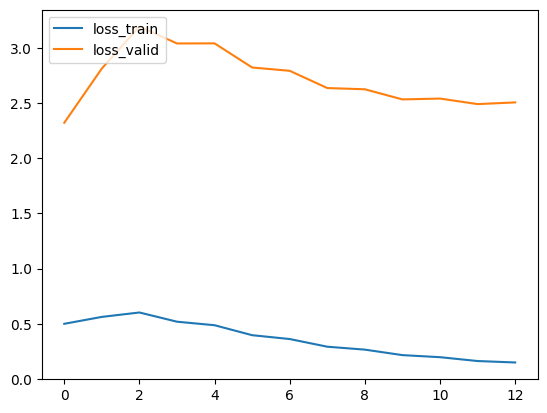

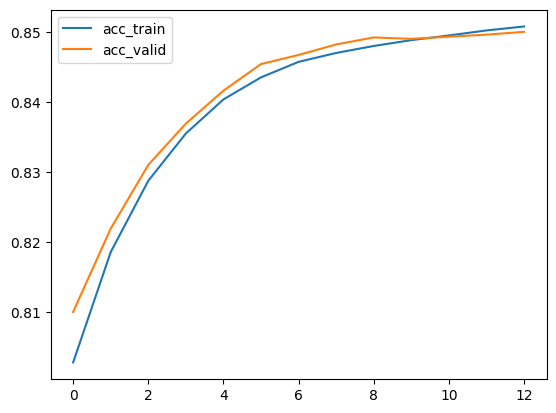

------ Training: 13 ------
Loss train: 0.125, accuracy train: 0.851
Loss valid: 2.482, accuracy valid: 0.851


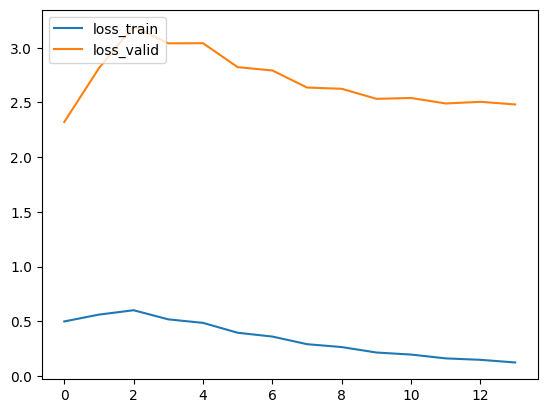

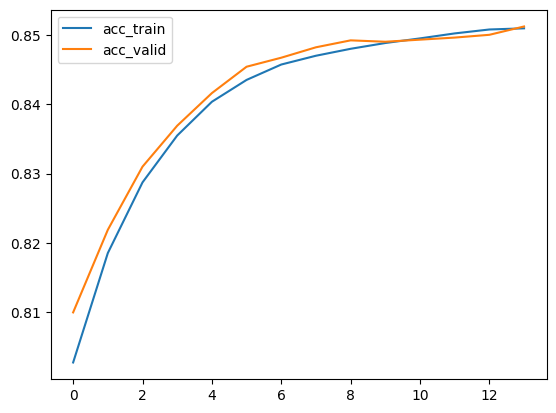

------ Training: 14 ------
Loss train: 0.116, accuracy train: 0.851
Loss valid: 2.506, accuracy valid: 0.852


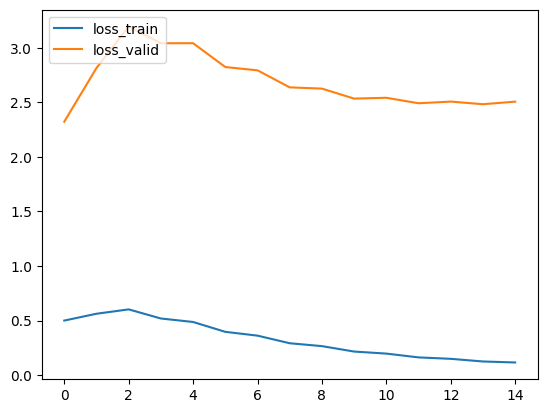

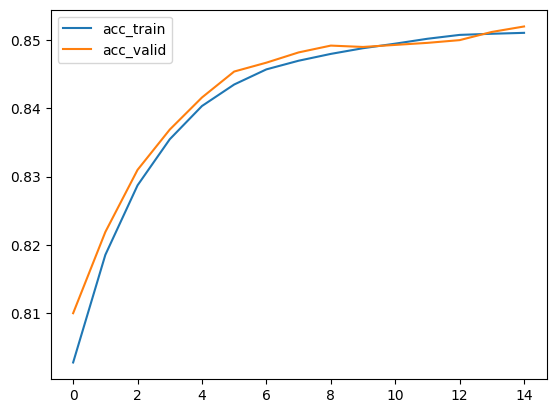

Loss valid: 2.506, accuracy valid: 0.852


/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:81: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:71: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [ ]:

# Training Model
list_loss_train = []
list_loss_valid = []
list_accuracy_train = []
list_accuracy_valid = []
for i in range(train_epochs):
    print(f"------ Training: {i} ------")
    loss_train, accuracy_train = model.fit(torch.from_numpy(train_data), torch.from_numpy(train_labels), beta, gamma)
    loss_valid, accuracy_valid = model.evaluate(torch.from_numpy(valid_data), torch.from_numpy(valid_labels))

    print(f"Loss train: {loss_train.item():.3f}, accuracy train: {accuracy_train.item():.3f}")
    print(f"Loss valid: {loss_valid.item():.3f}, accuracy valid: {accuracy_valid.item():.3f}")

    # Append loss and accuracy
    list_loss_train.append(loss_train.item())
    list_loss_valid.append(loss_valid.item())
    list_accuracy_train.append(accuracy_train.item())
    list_accuracy_valid.append(accuracy_valid.item())

    # Drawing loss, accuracy of train and valid
    model.drawcurve(list_loss_train, list_loss_valid, 1, 'loss_train', 'loss_valid')
    model.drawcurve(list_accuracy_train, list_accuracy_valid, 2, 'acc_train', 'acc_valid')

# Evaluate Model on test set
test_data = mnist_valid.test_data.numpy().reshape(-1, 28*28).T.astype(np.float32)
test_labels = F.one_hot(mnist_valid.test_labels, num_classes=10).numpy().T.astype(np.float32)

loss, accuracy = model.evaluate(torch.from_numpy(test_data), torch.from_numpy(test_labels))
print(f"Loss valid: {loss.item():.3f}, accuracy valid: {accuracy.item():.3f}")